In [2]:
import pandas as pd
import numpy as np
from random import gauss
from pandas.plotting import autocorrelation_plot
import warnings
import itertools
from random import random

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# import matplotlib as mpl
import seaborn as sns

In [25]:
air_df=pd.read_csv('/content/passengers.csv')
air_df.head(10)

,date,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


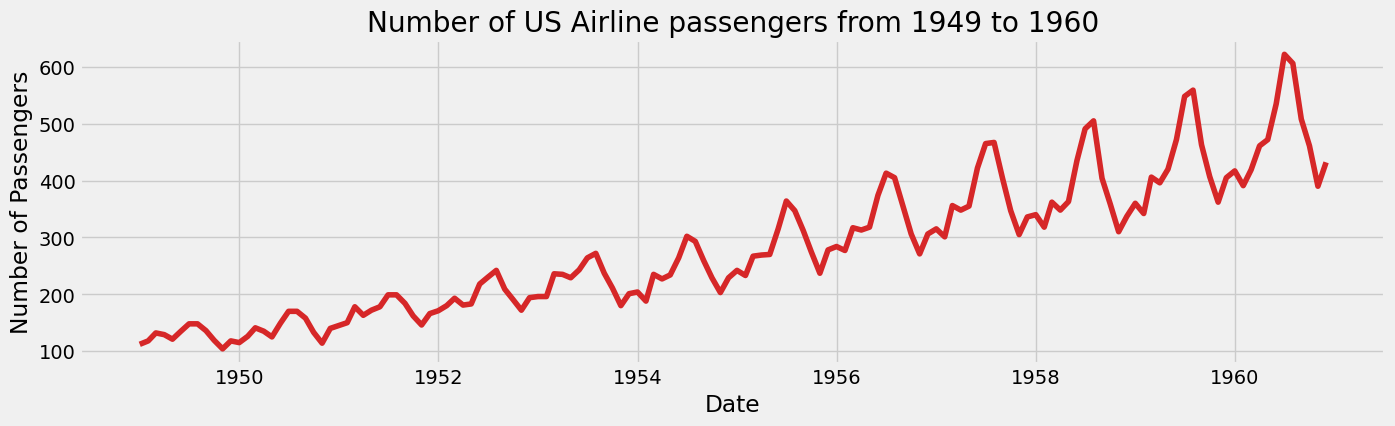

In [26]:

def plot_df(df, x, y, title="", xlabel='Date', ylabel='Number of Passengers', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

air_df['date'] = pd.to_datetime(air_df['date'])
air_df.columns=['Date','Number of Passengers']
plot_df(air_df, x=air_df['Date'], y=air_df['Number of Passengers'], title='Number of US Airline passengers from 1949 to 1960')

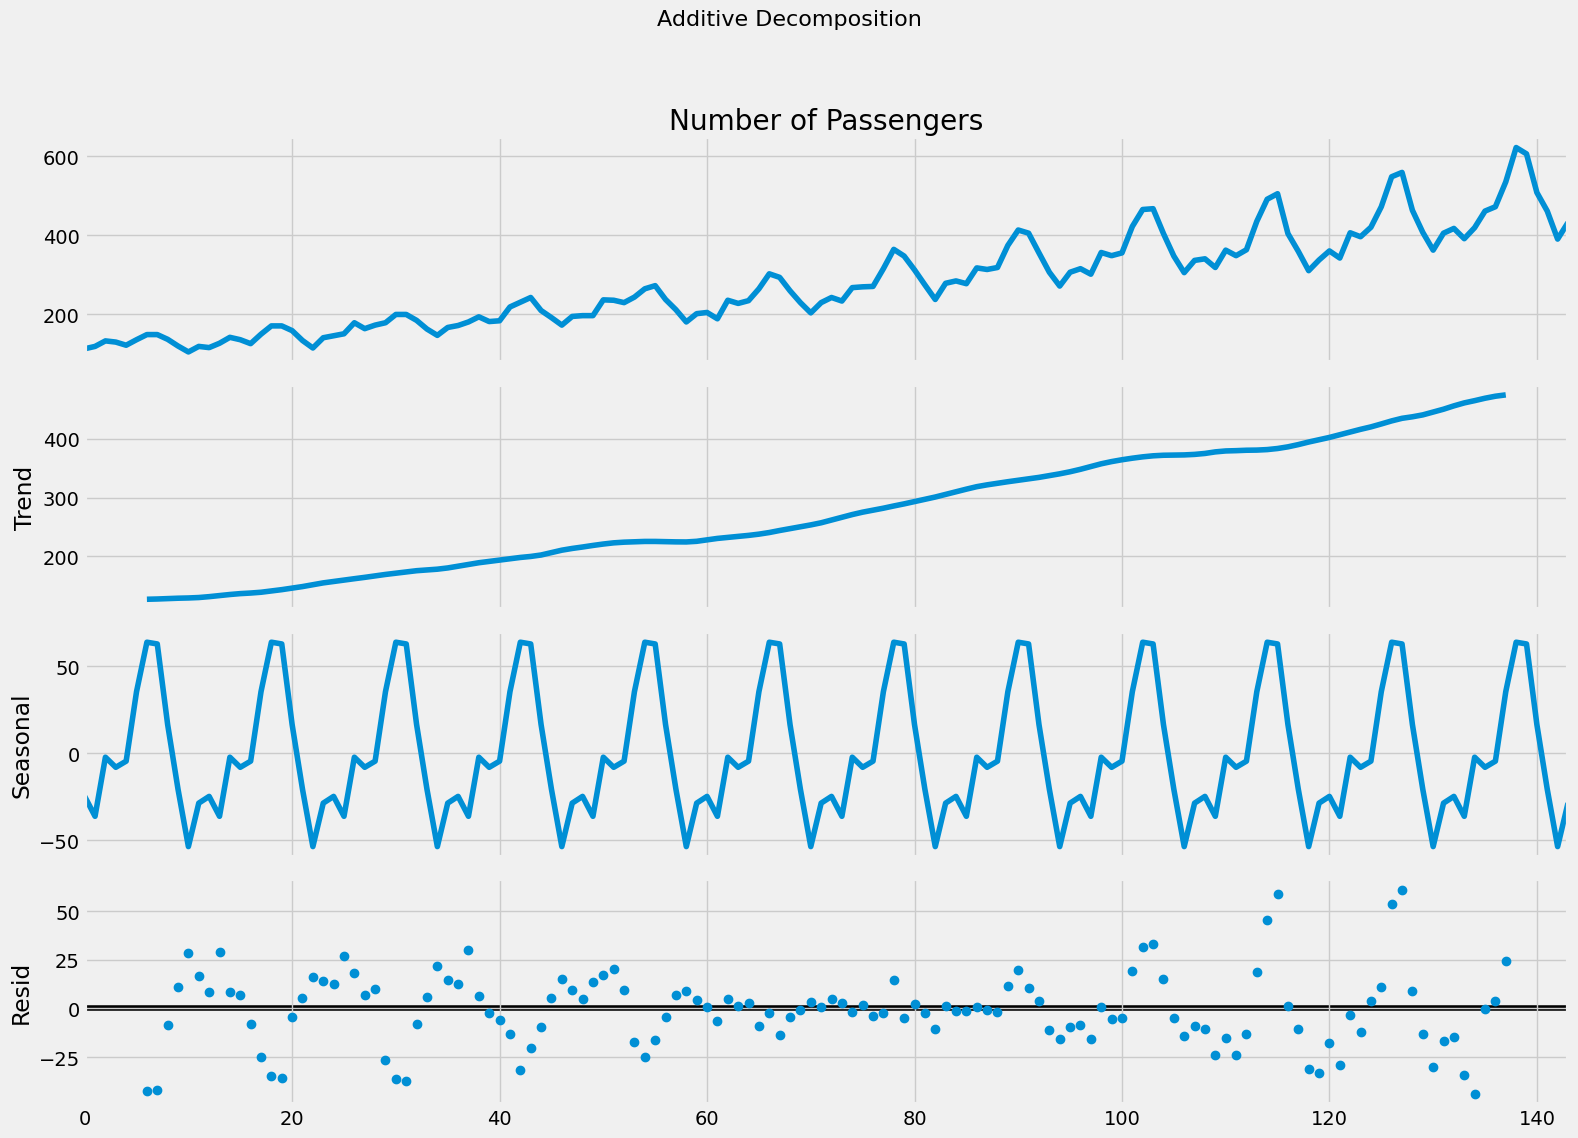

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


# Multiplicative Decomposition
multiplicative_decomposition = seasonal_decompose(air_df['Number of Passengers'], model='multiplicative', period=12)

# Additive Decomposition
additive_decomposition = seasonal_decompose(air_df['Number of Passengers'], model='additive', period=12)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})


additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

If we look at the residuals of the additive decomposition closely, it has some pattern left over

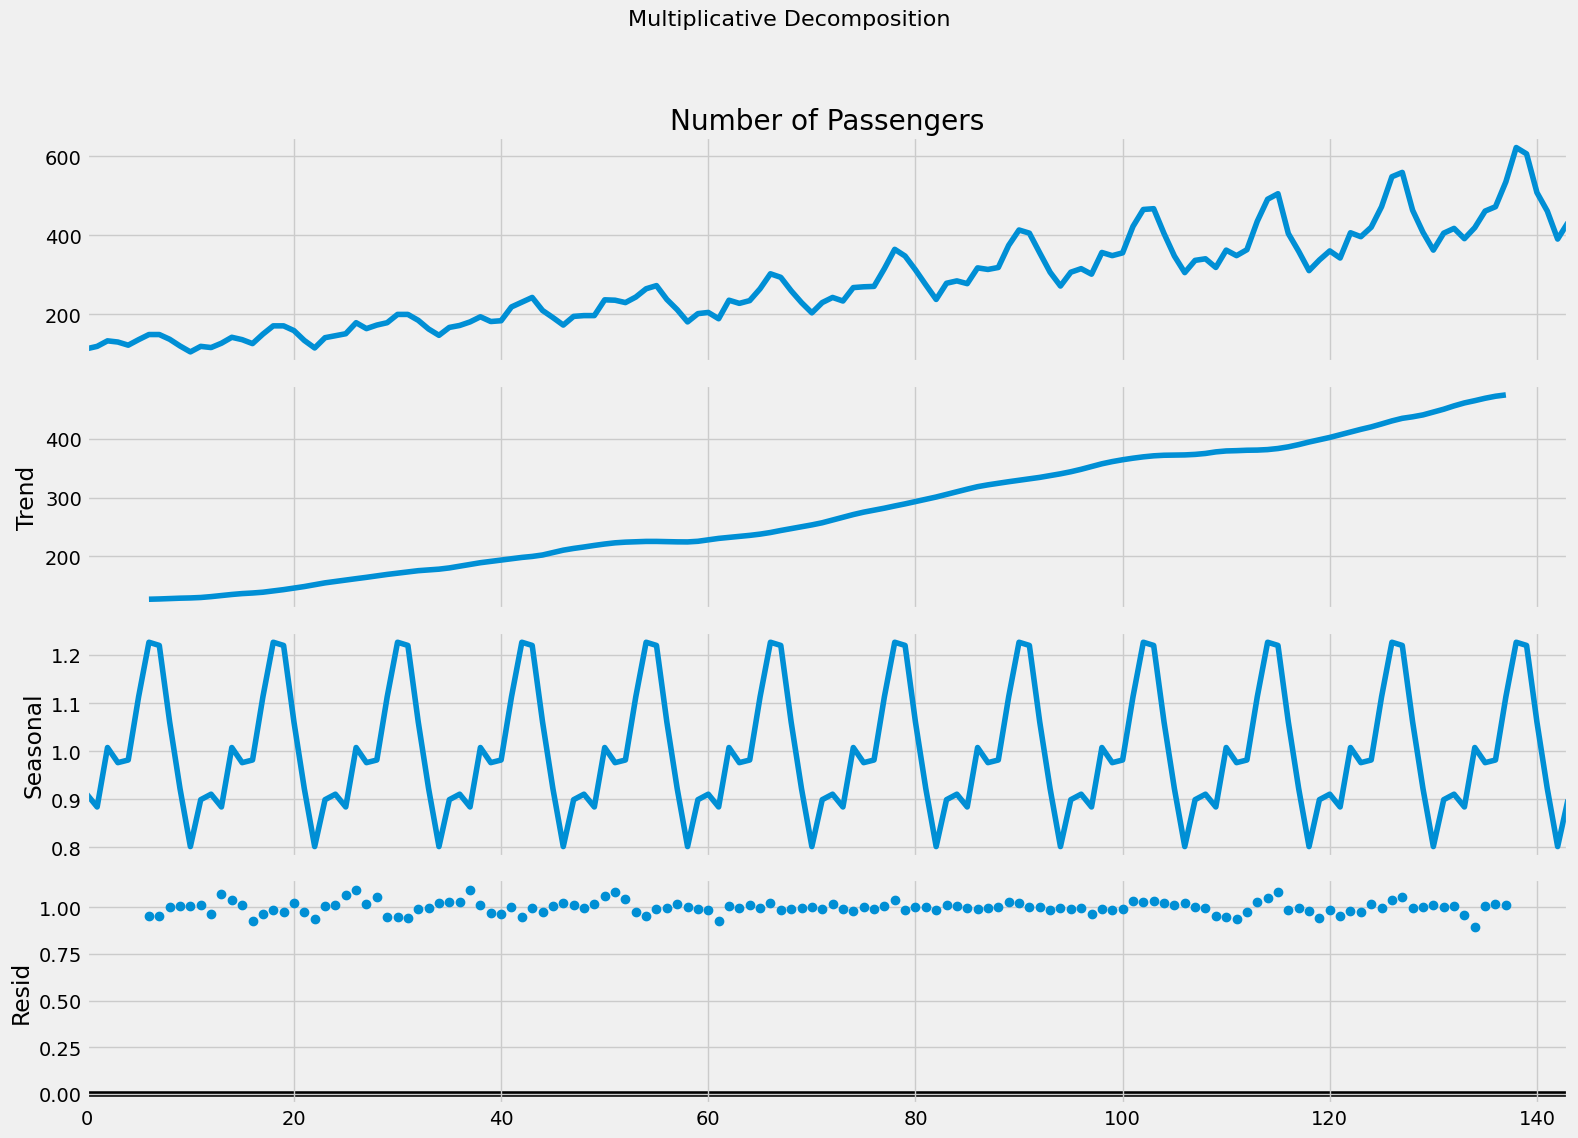

In [6]:
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Not much of a qualitative change in trend and seasonality components, but the residuals looks much more stable around a constant level - such phenomenon does not of course imply stationarity by itself, but at least a clear signal in the opposite direction is not there anymore.

**Stationary and Non-Stationary Time Series**

In [7]:
X = air_df['Number of Passengers'].values
split =  int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print(f'Mean:\nsubset1: {mean1:.2f} vs subset2: {mean2:.2f}\n')
print(f'Variance:\nsubset1: {var1:.2f} vs subset2: {var2:.2f}')



Mean:
subset1: 182.90 vs subset2: 377.69

Variance:
subset1: 2244.09 vs subset2: 7367.96


The values are clearly very different across the two data subsets, which strongly suggests non-stationarity.



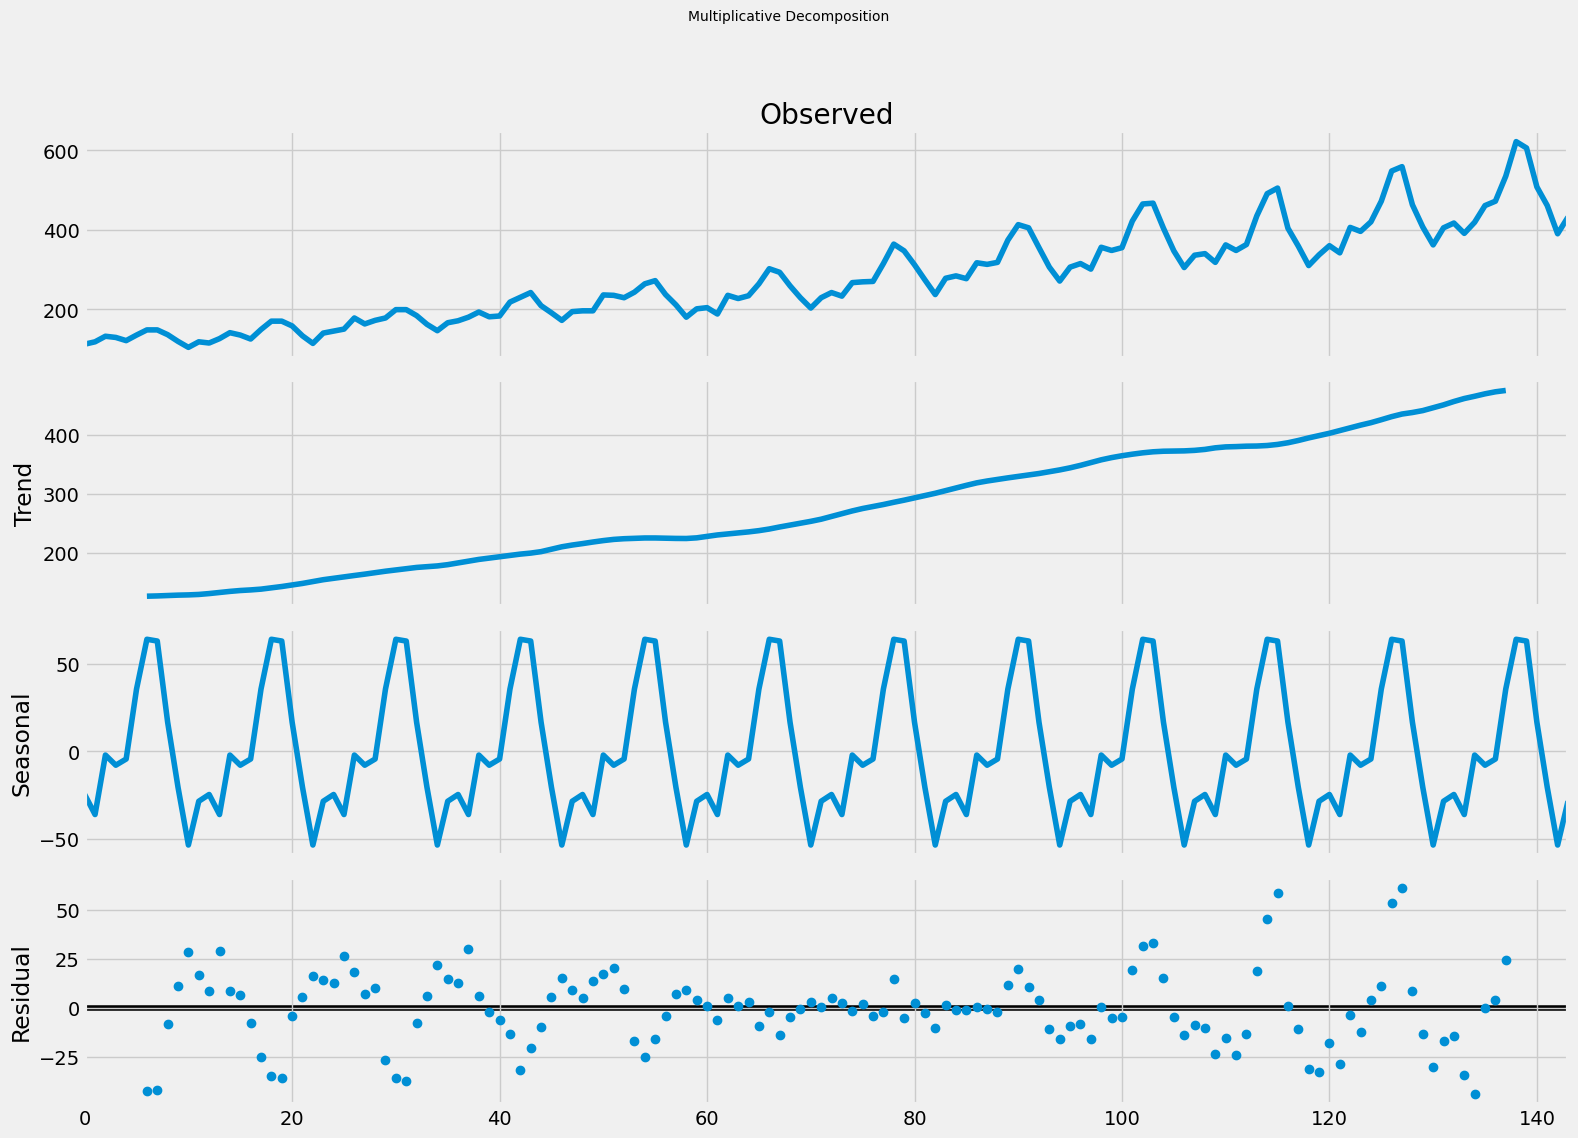

In [8]:
decomposition = seasonal_decompose(X, model='additive', period =12)
decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


ADF test for stationarity


In [9]:
result = adfuller(decomposition.trend[10:-10])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('\n')
print('p-value is not less than 0.05, so its non-stationary')

ADF Statistic: 1.025948
p-value: 0.994532


p-value is not less than 0.05, so its non-stationary


In [10]:
result = adfuller(decomposition.seasonal[10:-10])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('\n')
print('p-value is less than 0.05')
print('It is stationary')

ADF Statistic: -5553666457109205.000000
p-value: 0.000000


p-value is less than 0.05
It is stationary


In [11]:
result = adfuller(decomposition.resid[10:-10])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('\n')
print('p-value is less than 0.05')
print('It is stationary')

ADF Statistic: -5.029170
p-value: 0.000019


p-value is less than 0.05
It is stationary


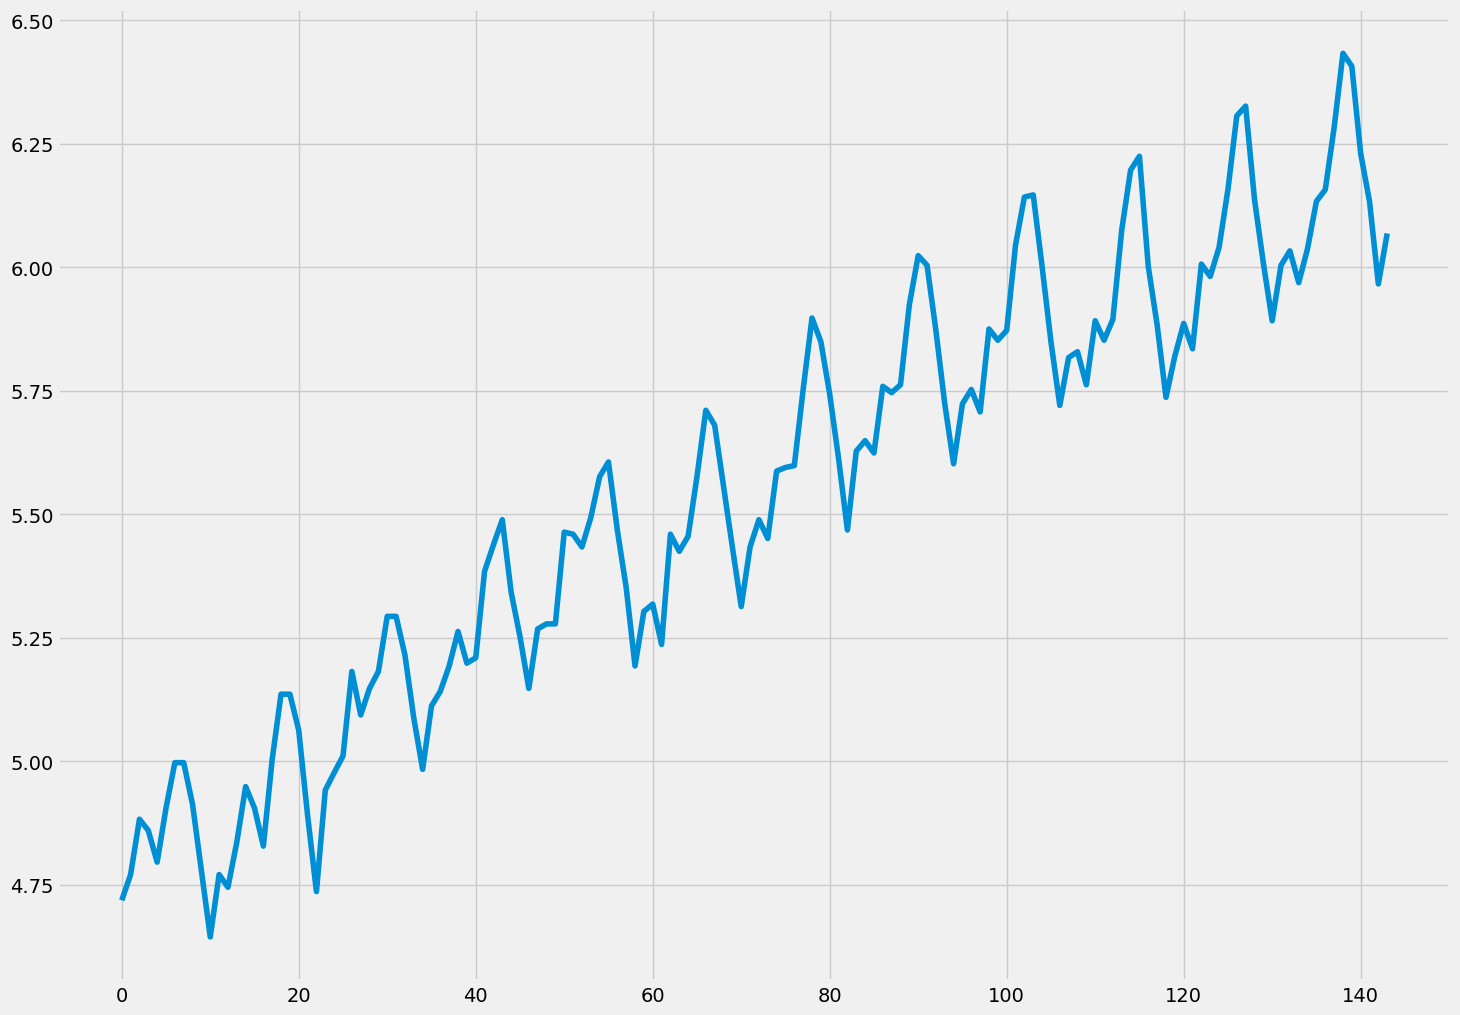

In [13]:
air_df['passengers2'] = np.log(air_df['Number of Passengers'])
air_df.passengers2.plot()
plt.show()

In [15]:
result = adfuller(air_df.passengers2)
print('p-value: %f' % result[1])

print('\n')
print('p-value is still not less than 0.05, so its non-stationary')
print('\n')

print('But,the p-value has dropped from 0.994532 to 0.422367')

p-value: 0.422367


p-value is still not less than 0.05, so its non-stationary


But,the p-value has dropped from 0.994532 to 0.422367


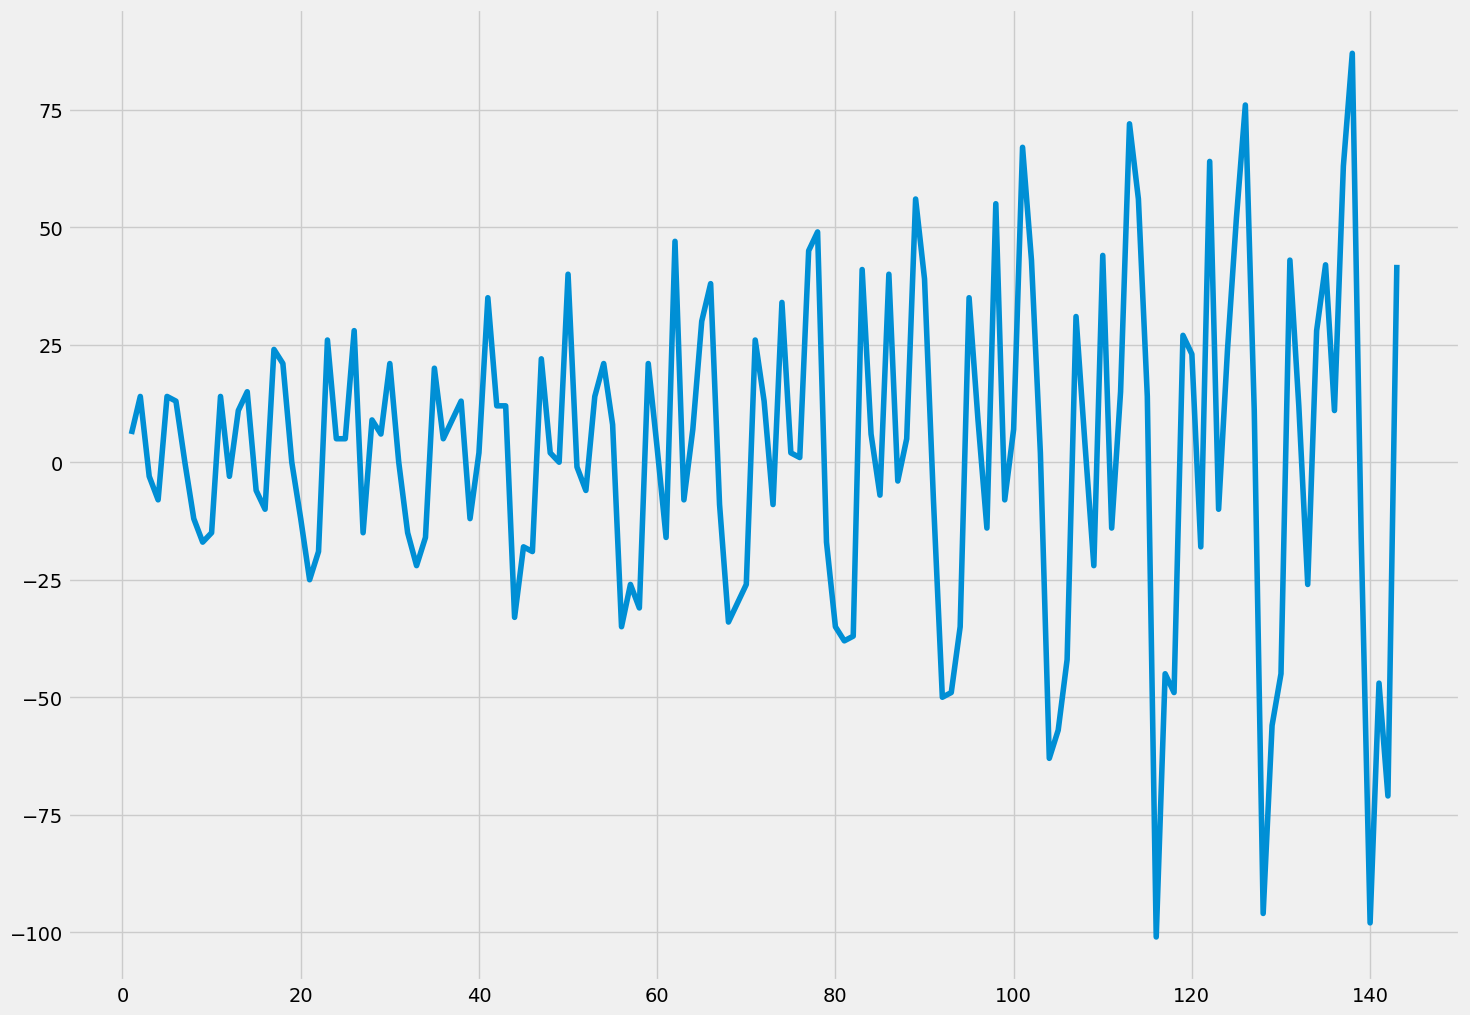

In [16]:
air_df['passengers3'] = air_df['Number of Passengers'].diff()
air_df.passengers3.plot()
plt.show()

In [17]:
result = adfuller(air_df.passengers3[10:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print('\n')
print('p-value is still not less than 0.05, so its non-stationary')
print('\n')

print('But again,the p-value has dropped from 0.422367 to 0.054094')

ADF Statistic: -2.830154
p-value: 0.054094


p-value is still not less than 0.05, so its non-stationary


But again,the p-value has dropped from 0.422367 to 0.054094


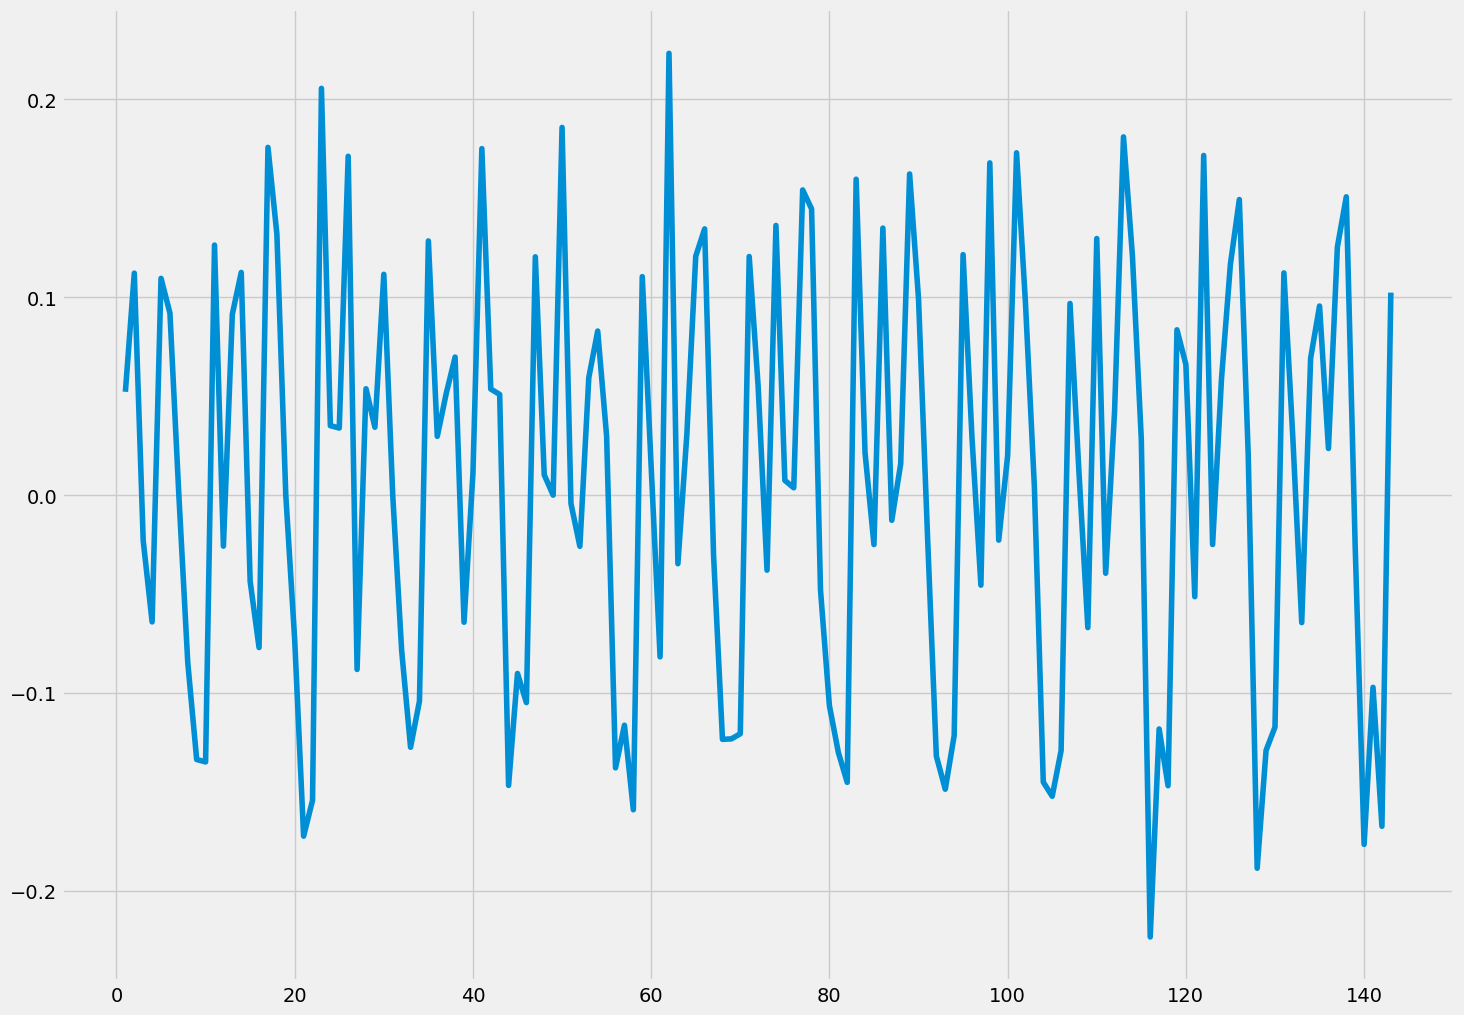

In [19]:
air_df['passengers4'] = air_df['Number of Passengers'].apply(np.log).diff()
air_df.passengers4.plot()
plt.show()

In [20]:
result = adfuller(air_df.passengers4[10:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print('Finally,p-value is less than 0.05, Now it is stationary')

ADF Statistic: -3.086110
p-value: 0.027598
Finally,p-value is less than 0.05, Now we are stationary


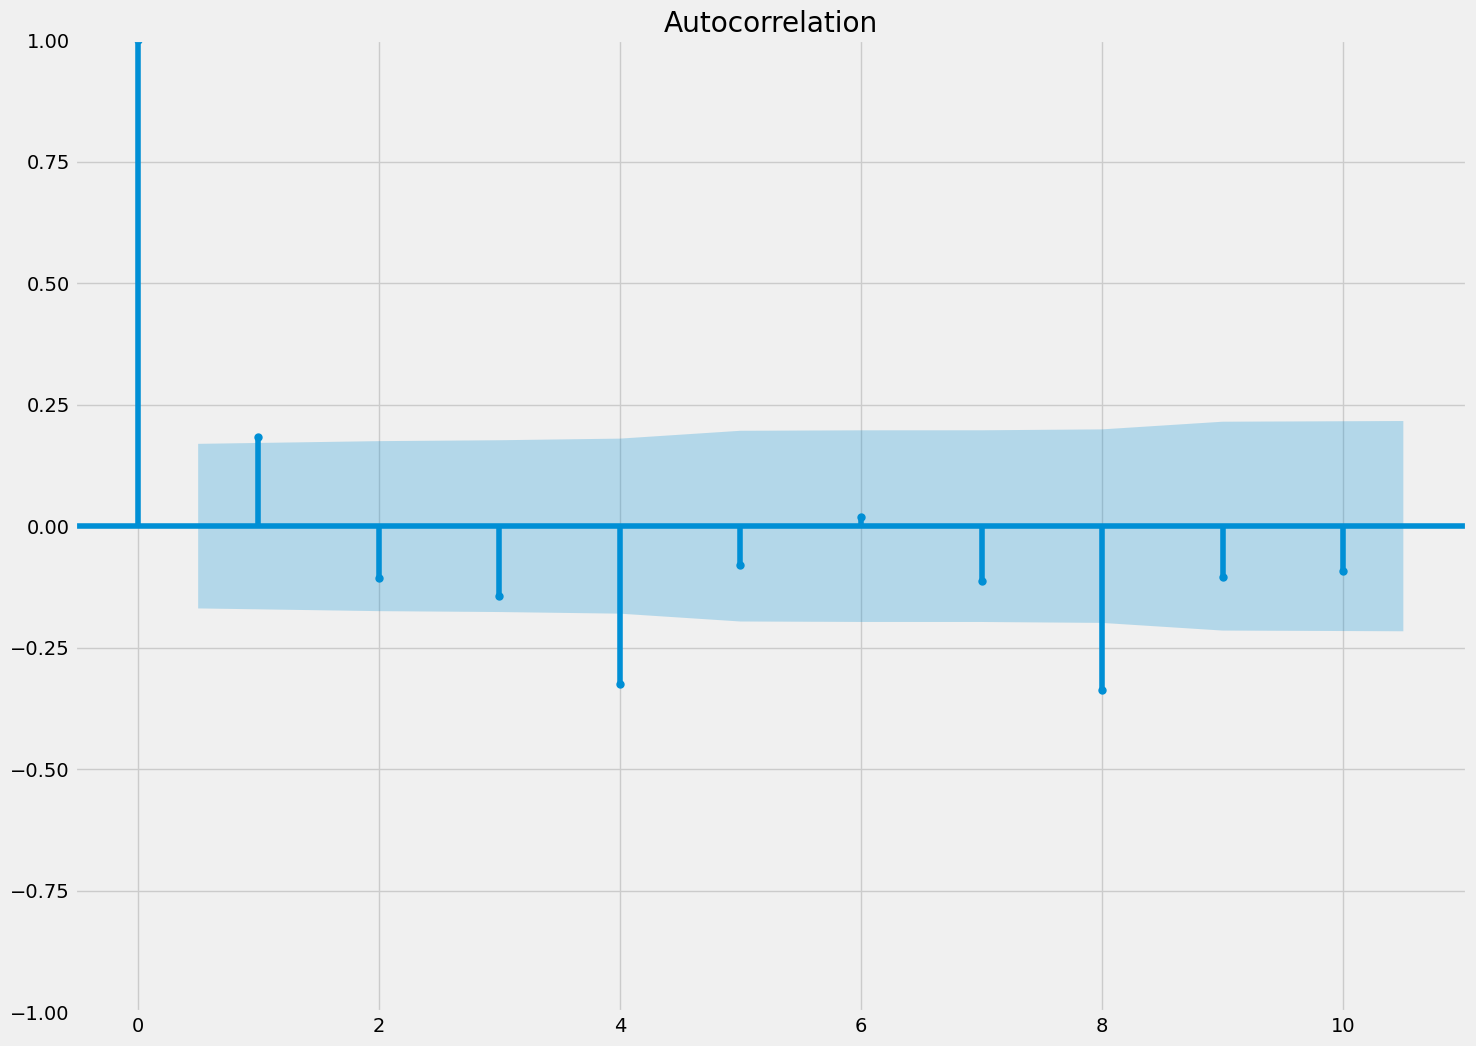

In [21]:
plot_acf(air_df['passengers4'][10:], lags = 10)
plt.show()

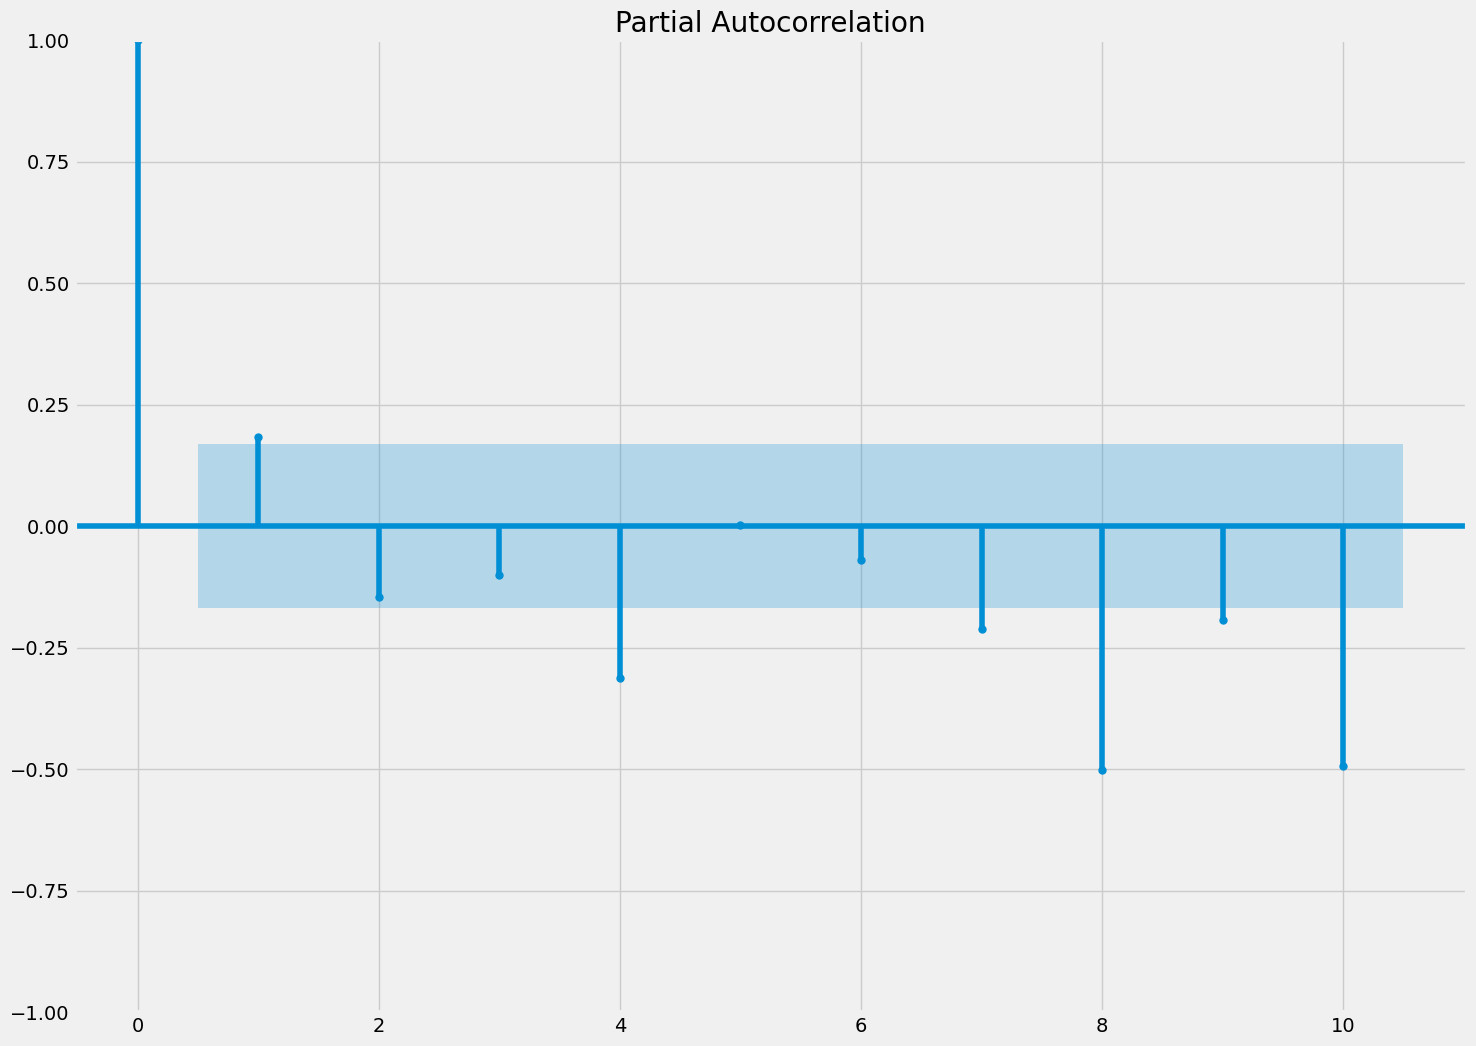

In [22]:
plot_pacf(air_df['passengers4'][10:], lags = 10)
plt.show()

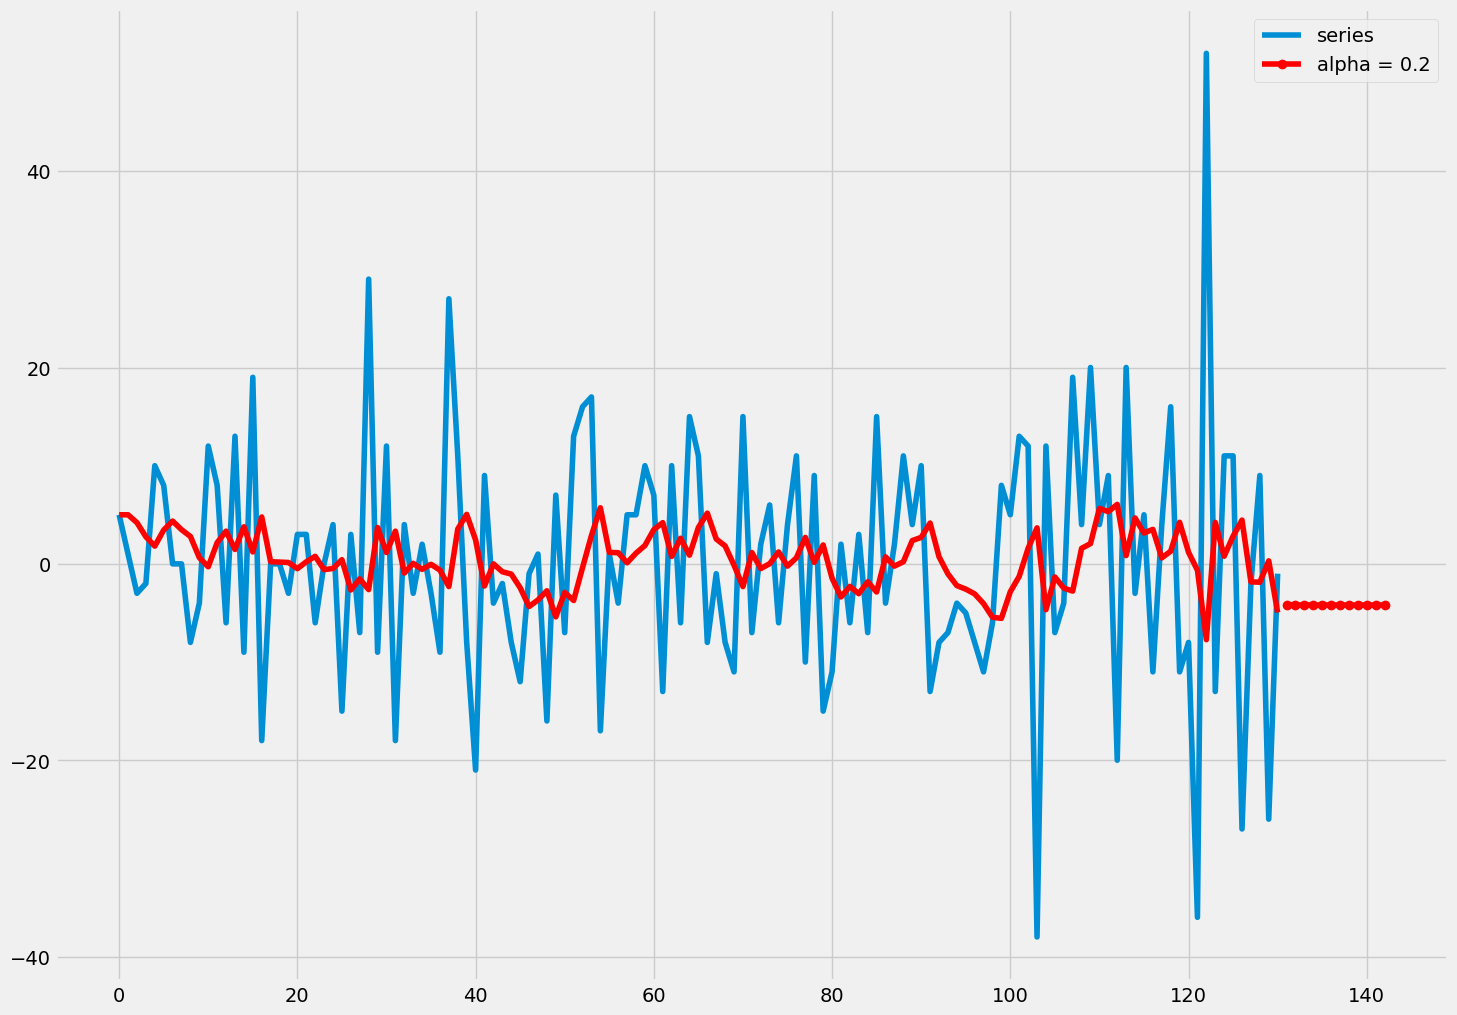

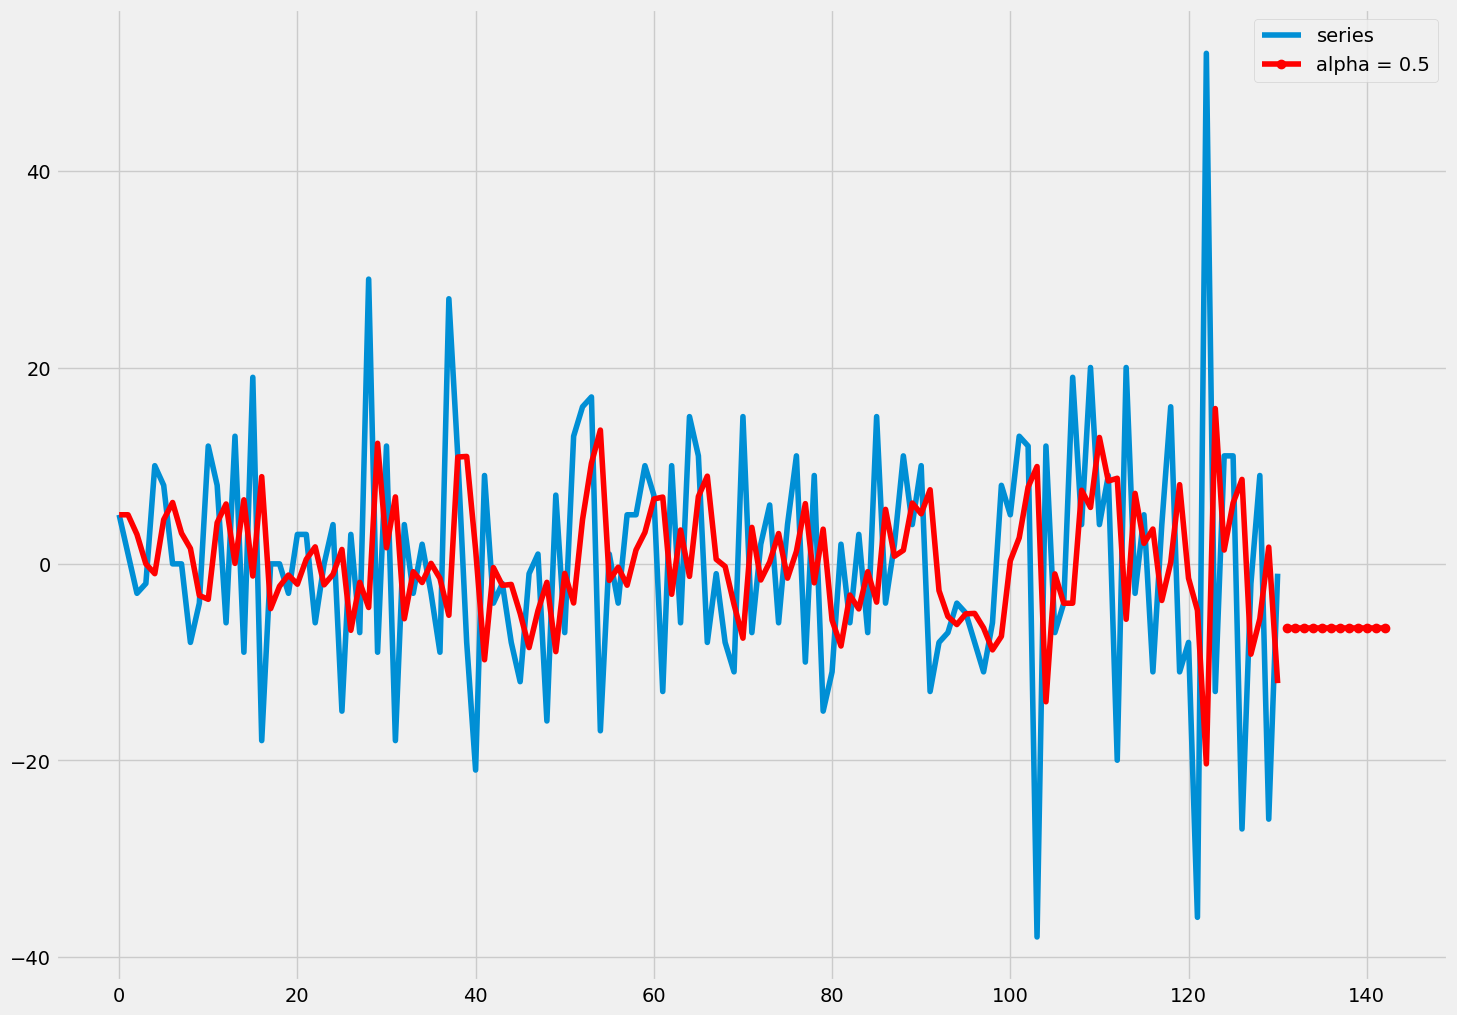

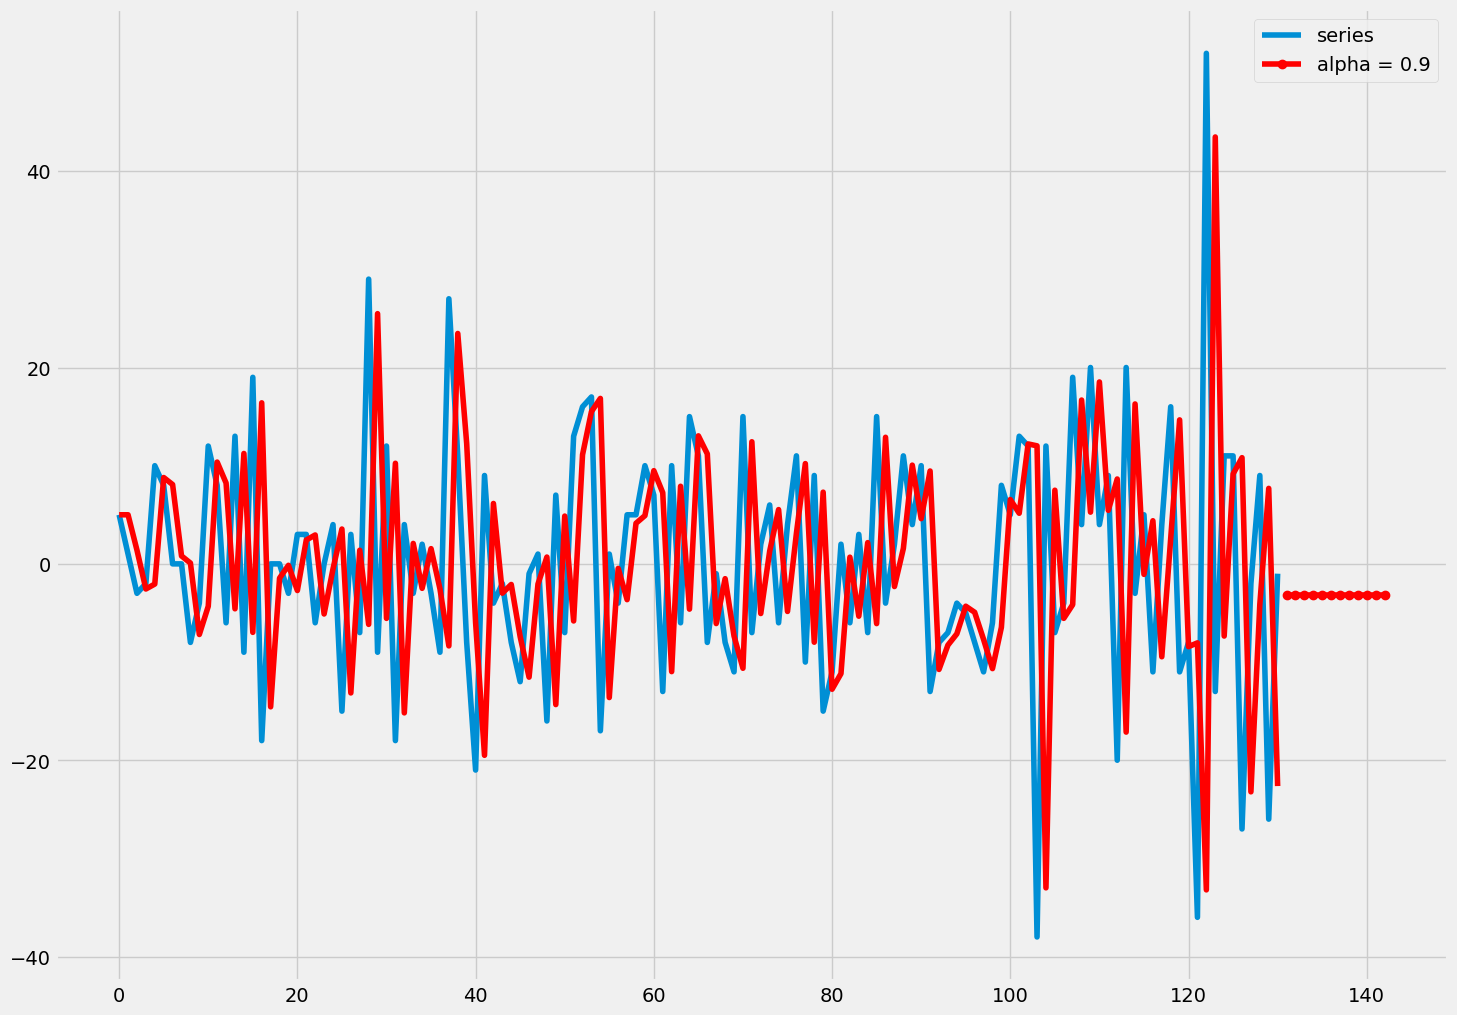

In [9]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

for alpha_sm in [0.2 , 0.5, 0.9]:

    df = pd.read_csv('/content/exp1.csv', header = None); df.columns = ['series']
    df.plot.line()
    fit1 = SimpleExpSmoothing(df).fit(smoothing_level = alpha_sm  ,optimized=False)
    fcast1 = fit1.forecast(12).rename('alpha = ' + str(alpha_sm))
    fcast1.plot(marker='o', color='red', legend=True)
    fit1.fittedvalues.plot(  color='red')
    plt.show()

As you can see from the graphs above, the for small values of the smoothing constant  
α
  most of the variation has been removed and we have a series following just the general trend; on the other hand, high value of the  
α
  parameter results in hardly any smoothing at all and the new series follows the original very closely.

**Double Exponential Smoothing**

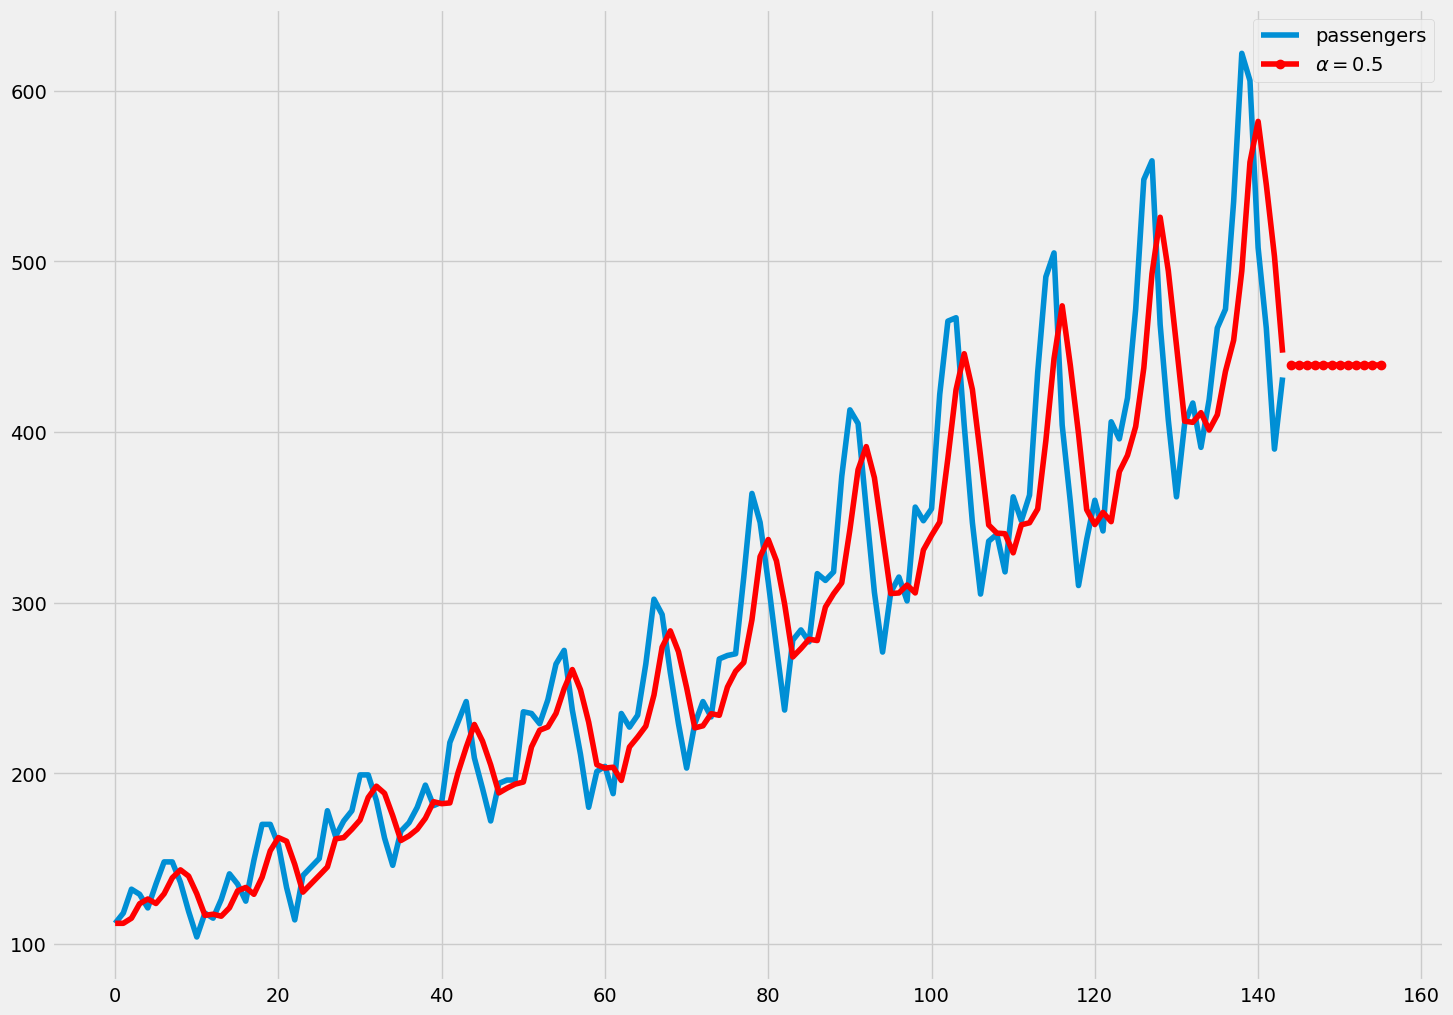

<ipython-input-10-0b8465309d71>:12: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fit1 = Holt(df).fit(smoothing_level=0.5, smoothing_slope=0.5, optimized=False)


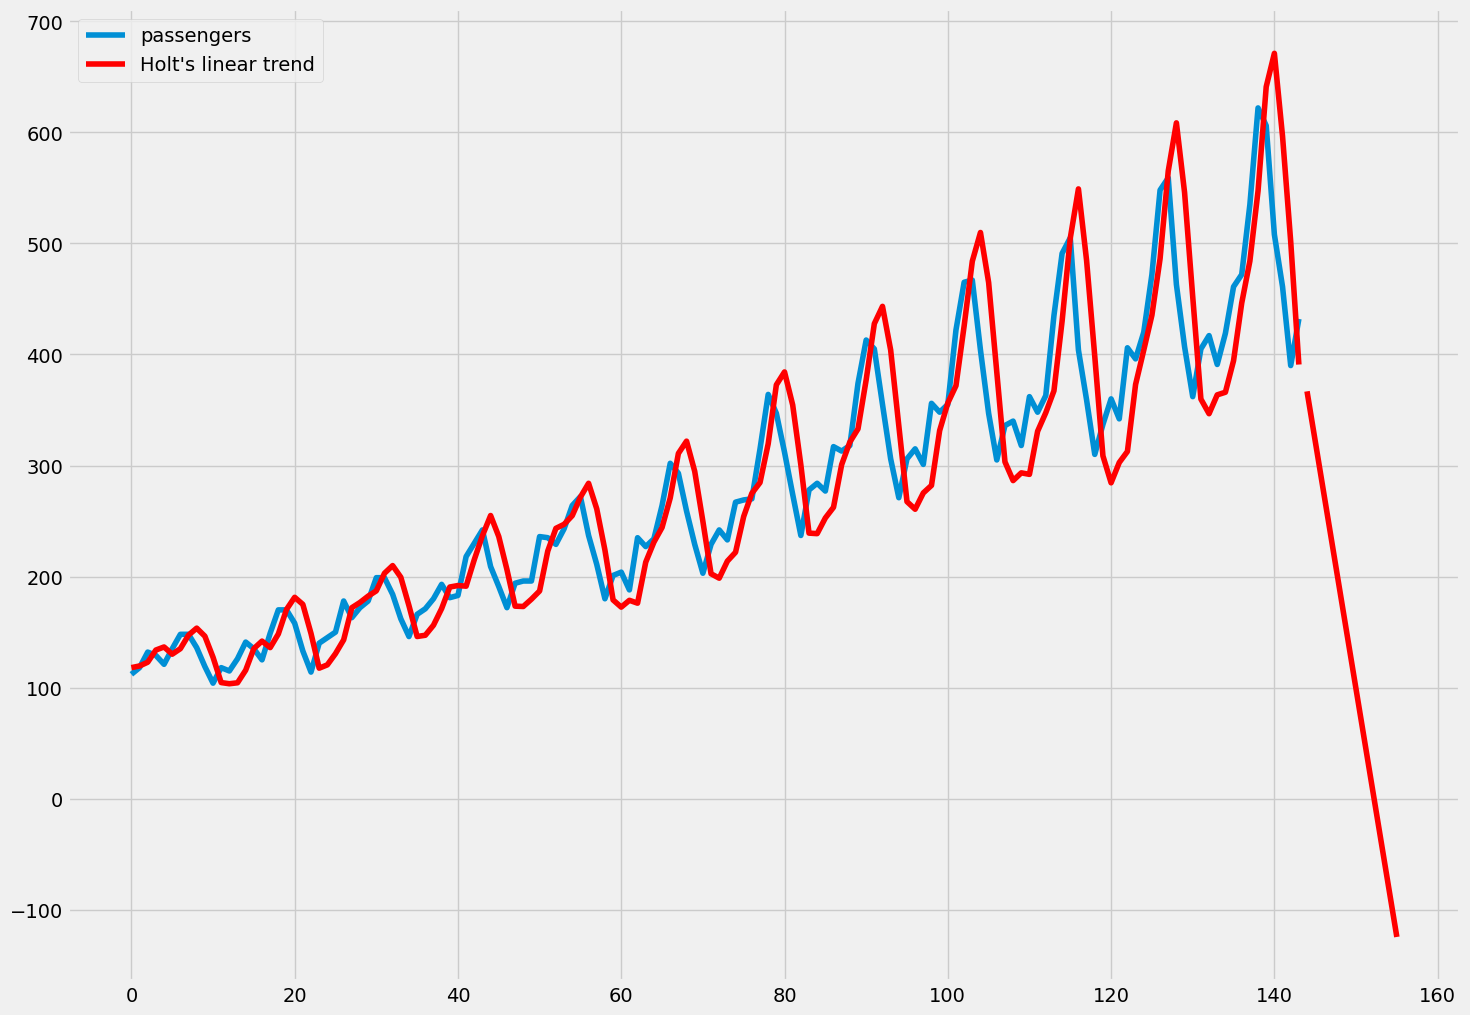

In [10]:
alpha = 0.5
df = pd.read_csv('passengers.csv', usecols = ['passengers'])
df.plot.line()
fit1 = SimpleExpSmoothing(df).fit(smoothing_level= alpha,optimized=False)
fcast1 = fit1.forecast(12).rename(r'$\alpha=0.5$')
fcast1.plot(marker='o', color='red', legend=True)
fit1.fittedvalues.plot(  color='red')
plt.show()

df.plot.line()

fit1 = Holt(df).fit(smoothing_level=0.5, smoothing_slope=0.5, optimized=False)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")
fit1.fittedvalues.plot(color='red')
fcast1.plot(color='red', legend=True)

plt.show()

It seems like we are moving in the right direction - the forecast going forward is not constant, but follows a trend. However, it is simply an extrapolation of the most recent (smoothed) trend in the data which means we can expect the forecast to turn negative shortly. This is suspicious in general, and clearly renders the forecast unusable in the domain context.

**Triple Exponential Smoothing**

<function matplotlib.pyplot.show(close=None, block=None)>

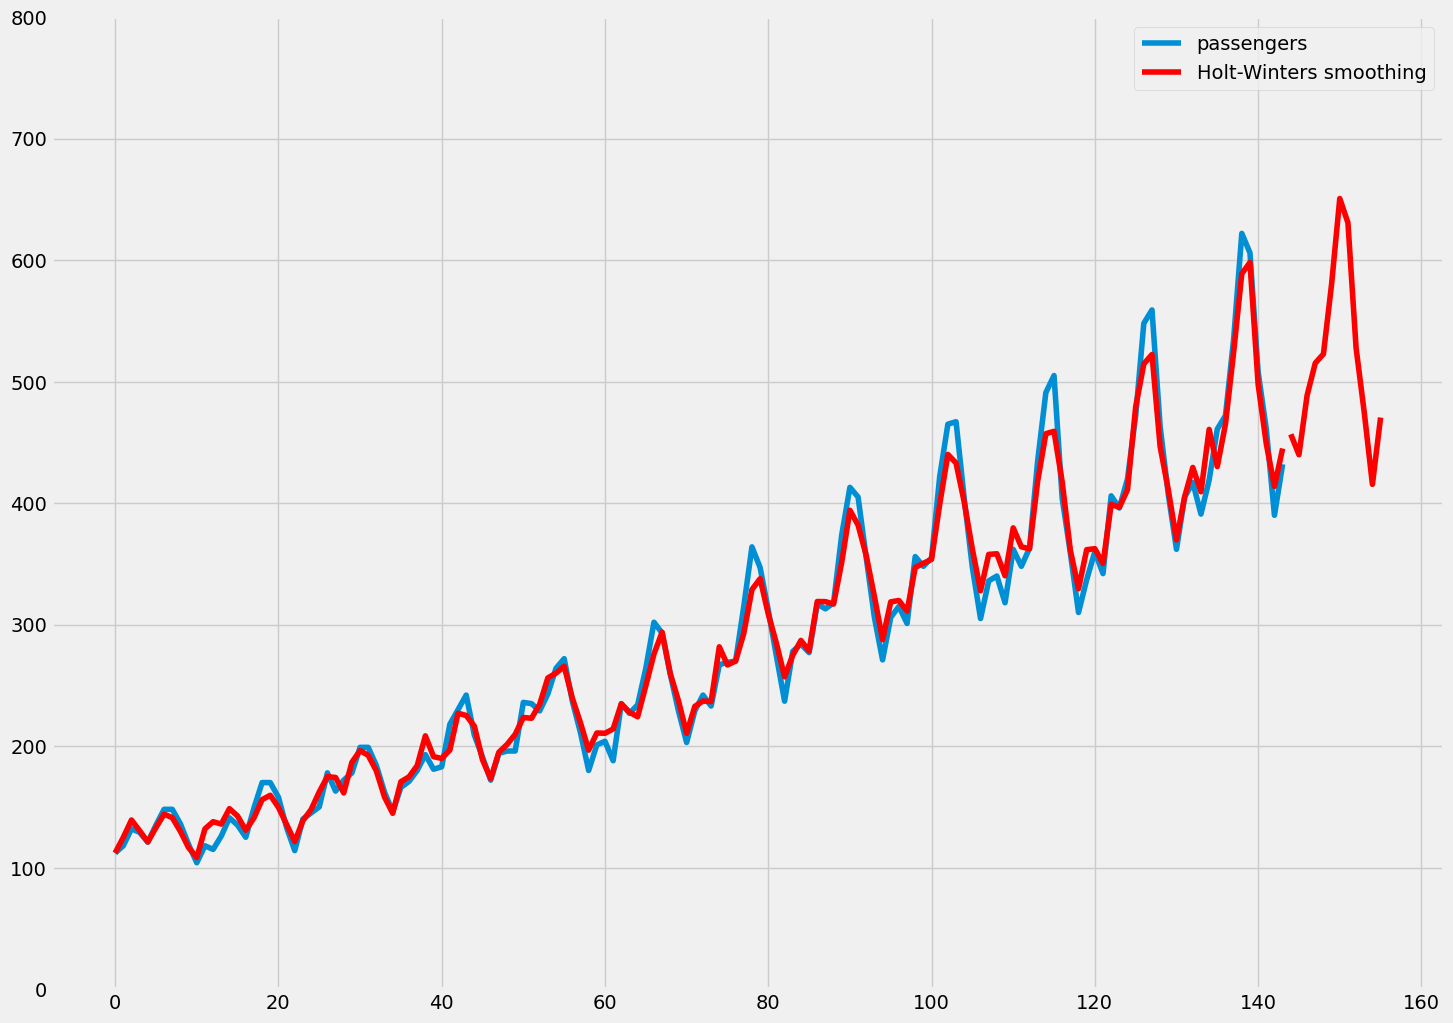

In [11]:
alpha = 0.5
df = pd.read_csv('/content/passengers.csv', usecols = ['passengers'])
df.plot.line()
fit1 = ExponentialSmoothing(df, seasonal_periods=12, trend='add', seasonal='add')
fit1 = fit1.fit(smoothing_level=0.5)#,use_boxcox=True)
fit1.fittedvalues.plot(color='red')
fit1.forecast(12).rename("Holt-Winters smoothing").plot(color='red', legend=True)

plt.ylim(0, 800); plt.show

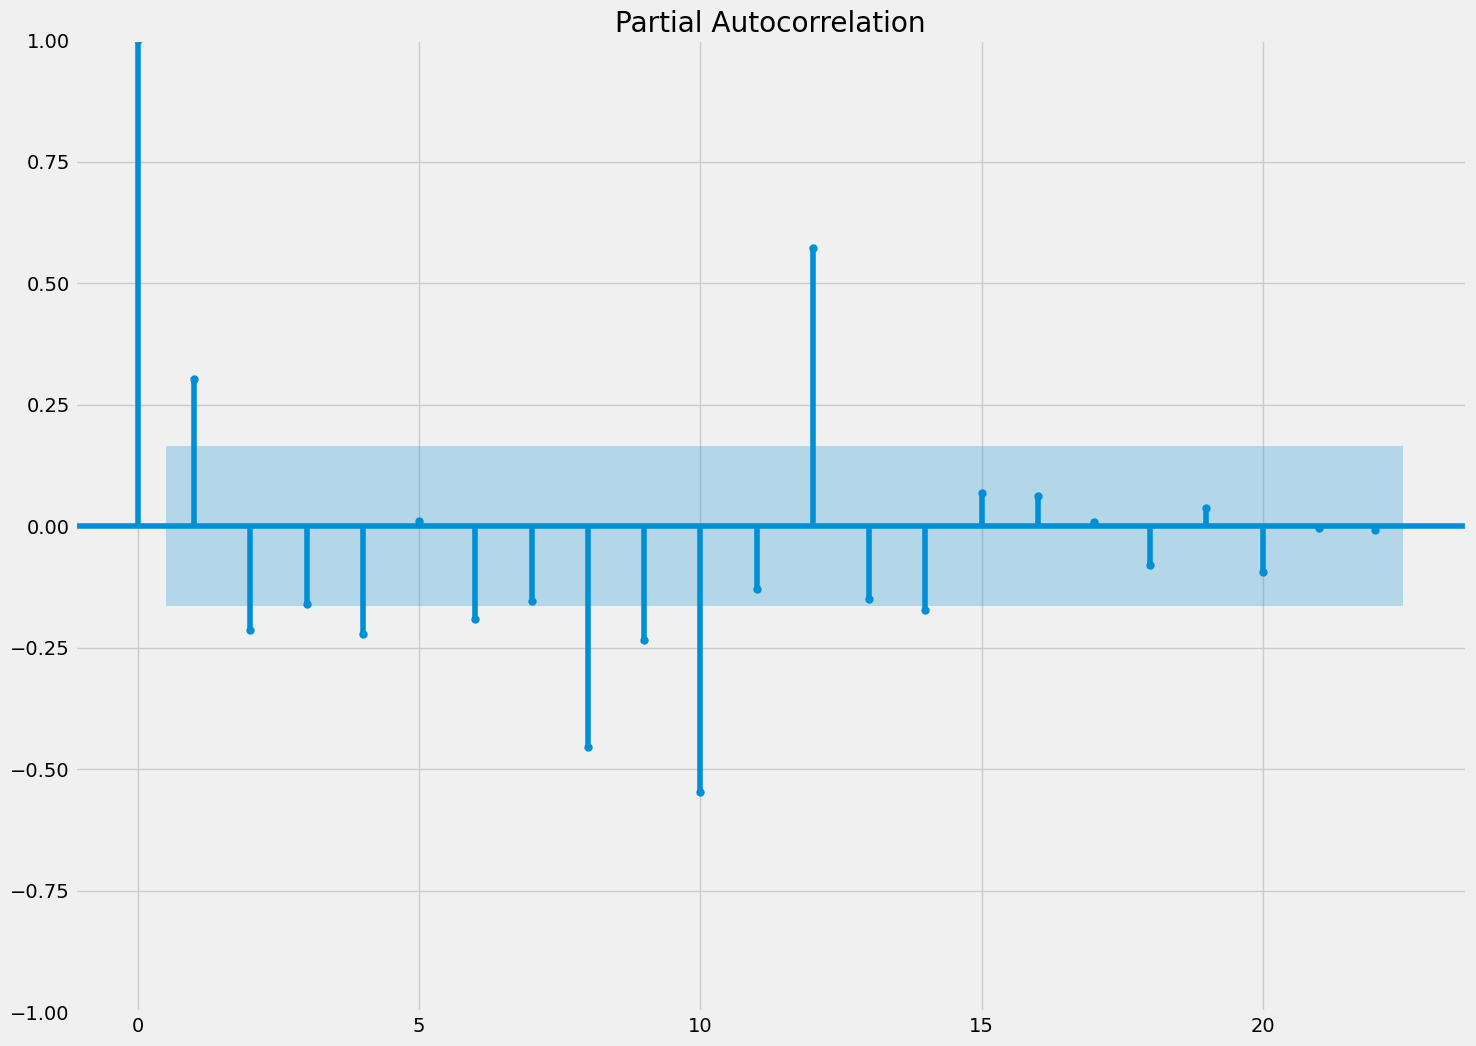

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(air_df['Number of Passengers'].diff().dropna());

Here we can see that the first lag is significantly out of the limit and the second one is also out of the significant limit but it is not that far so we can select the order of the p as 1.

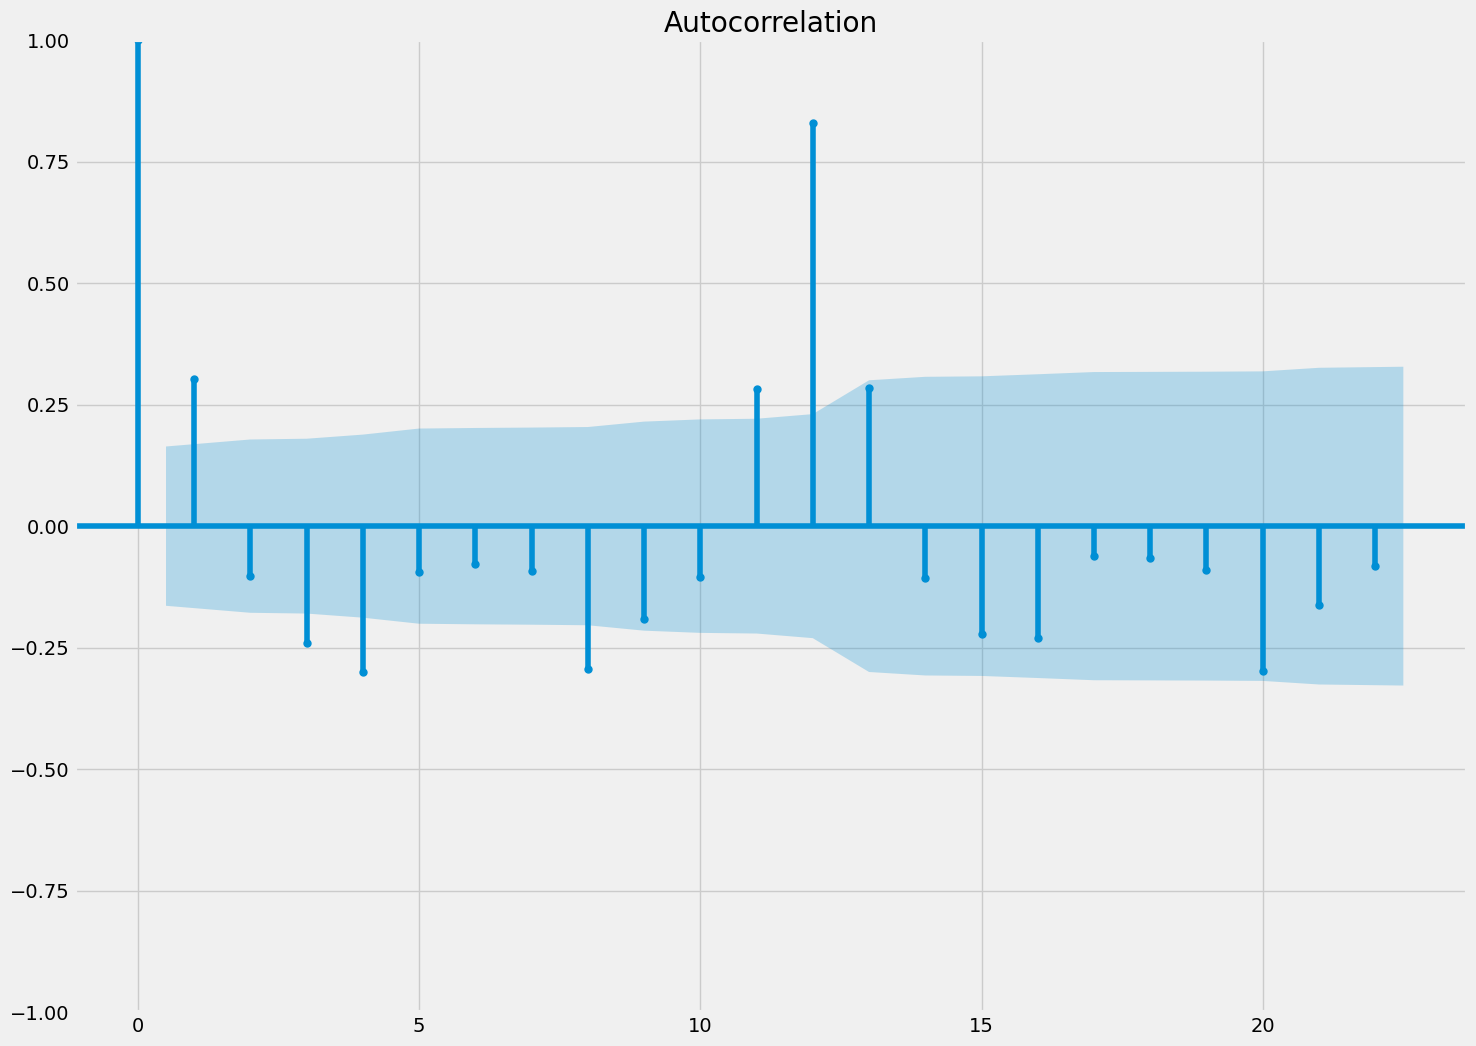

In [13]:
plot_acf(air_df['Number of Passengers'].diff().dropna());

Here we can see that 2 of the lags are out of the significance limit so we can say that the optimal value of our q (MA) is 2.